In [114]:
import ccxt
import pandas as pd
import numpy as np

# Initialize Binance
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1m'  # hourly candles
limit = 10000  # number of candles to fetch

# Fetch OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

# Convert to DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)


In [115]:
# ===============================
# 2. Calculate RSI
# ===============================
import ta
df["RSI"] = ta.momentum.RSIIndicator(df["close"], window=14).rsi()


In [116]:
# ===============================
# 3. MACD Calculation
# ===============================
df["EMA12"] = df["close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["Histogram"] = df["MACD"] - df["Signal"]


In [117]:
import talib
df["DEMA9"] = talib.DEMA(df["close"].values, timeperiod=9)

In [118]:
# ------------------------------
# 2. Calculate SMA (3 closes)
# ------------------------------
sma_window = 3
df['SMA'] = ta.trend.sma_indicator(df['close'], window=sma_window)


In [119]:
# ------------------------------
# 2. Compute TSI
# ------------------------------
def compute_tsi(close, r1=25, r2=13):
    delta = close.diff()
    ema1 = delta.ewm(span=r1, adjust=False).mean()
    ema2 = ema1.ewm(span=r2, adjust=False).mean()

    abs_delta = delta.abs()
    abs_ema1 = abs_delta.ewm(span=r1, adjust=False).mean()
    abs_ema2 = abs_ema1.ewm(span=r2, adjust=False).mean()

    tsi = 100 * (ema2 / abs_ema2)
    return tsi

df['TSI'] = compute_tsi(df['close'])


In [120]:
# ========================
# 2. Stochastic Oscillator
# ========================
period = 14
smooth_k = 3
smooth_d = 3

lowest_low = df["low"].rolling(period).min()
highest_high = df["high"].rolling(period).max()

df["%K"] = 100 * (df["close"] - lowest_low) / (highest_high - lowest_low)
df["%K"] = df["%K"].rolling(smooth_k).mean()
df["%D"] = df["%K"].rolling(smooth_d).mean()


In [121]:
df.dropna(inplace=True)

In [122]:
"""# ========================
# 3. Swing Highs / Lows
# ========================
lookback_swings = 5

def find_swings(prices, lb):
    labels = [0]*len(prices)
    for i in range(lb, len(prices)-lb):
        if prices[i] == max(prices[i-lb:i+lb+1]):
            labels[i] = -1   # swing high
        elif prices[i] == min(prices[i-lb:i+lb+1]):
            labels[i] = 1    # swing low
    return labels

df["Label"] = find_swings(df["close"].values, lookback_swings)
"""

'# ========================\n# 3. Swing Highs / Lows\n# ========================\nlookback_swings = 5\n\ndef find_swings(prices, lb):\n    labels = [0]*len(prices)\n    for i in range(lb, len(prices)-lb):\n        if prices[i] == max(prices[i-lb:i+lb+1]):\n            labels[i] = -1   # swing high\n        elif prices[i] == min(prices[i-lb:i+lb+1]):\n            labels[i] = 1    # swing low\n    return labels\n\ndf["Label"] = find_swings(df["close"].values, lookback_swings)\n'

In [123]:
import numpy as np

def adaptive_triple_barrier_labeling(df, mult=1, max_period=10):
    """
    Adaptive triple-barrier method based on volatility.
    - mult: how many standard deviations to use for barrier width
    - max_period: candles to look ahead
    """
    df = df.copy()
    df['vol'] = df['close'].pct_change().rolling(20).std()
    labels = np.ones(len(df), dtype=int)
    close = df['close'].values

    for i in range(len(df) - max_period):
        if np.isnan(df['vol'].iloc[i]):
            continue

        # Dynamic upper/lower barriers based on volatility
        upper = close[i] * (1 + mult * df['vol'].iloc[i])
        lower = close[i] * (1 - mult * df['vol'].iloc[i])
        future_prices = close[i+1:i+max_period+1]

        if np.any(future_prices >= upper):
            labels[i] = 2
        elif np.any(future_prices <= lower):
            labels[i] = 0
        else:
            labels[i] = 1

    df['Label'] = labels
    return df


In [124]:
df = adaptive_triple_barrier_labeling(df, mult=2, max_period=30)
print(df["Label"].value_counts())


Label
2    548
0    336
1     99
Name: count, dtype: int64


In [125]:
"""df['Label'] = df['Label'] + 1"""

"df['Label'] = df['Label'] + 1"

In [126]:
df.head(50)

,open,high,low,close,volume,RSI,EMA12,EMA26,MACD,Signal,Histogram,DEMA9,SMA,TSI,%K,%D,vol,Label
timestamp,,,,,,,,,,,,,,,,,,
2025-10-12 20:58:00,114990.15,115069.00,114960.87,114966.60,17.19037,38.853989,115030.651675,115038.618505,-7.966830,6.783233,-14.750063,114983.221306,114978.933333,-28.120460,10.811994,9.425769,NaN,1
2025-10-12 20:59:00,114966.61,114966.61,114900.00,114927.97,11.38383,34.701667,115014.854494,115030.422319,-15.567825,2.313022,-17.880847,114957.134464,114961.576667,-29.969537,9.485038,9.719303,NaN,1
2025-10-12 21:00:00,114927.97,114952.66,114803.75,114813.49,50.53410,25.876083,114983.875341,115014.353258,-30.477917,-4.245166,-26.232751,114898.059506,114902.686667,-34.281152,5.478565,8.591866,NaN,1
2025-10-12 21:01:00,114813.49,114920.00,114787.16,114920.00,21.97619,40.928785,114974.048366,115007.364128,-33.315763,-10.059285,-23.256477,114895.212352,114887.153333,-32.473404,11.830601,8.931402,NaN,1
2025-10-12 21:02:00,114920.00,114952.65,114891.43,114949.99,14.68083,44.355286,114970.347079,115003.114193,-32.767114,-14.600851,-18.166263,114905.178080,114894.493333,-29.863127,20.213371,12.507513,NaN,1
2025-10-12 21:03:00,114950.00,115095.55,114950.00,115084.15,28.17383,56.508924,114987.855220,115009.116845,-21.261625,-15.933006,-5.328619,114961.646223,114984.713333,-22.603257,39.182319,23.742097,NaN,1
2025-10-12 21:04:00,115084.15,115090.00,115025.32,115056.50,18.19405,53.896179,114998.415956,115012.626708,-14.210753,-15.588555,1.377803,114992.731985,115030.213333,-18.080686,48.206695,35.867462,NaN,1
2025-10-12 21:05:00,115056.50,115056.50,114949.05,114983.32,24.04818,47.620560,114996.093501,115010.455841,-14.362340,-15.343312,0.980972,114988.832793,115041.323333,-16.506954,52.767890,46.718968,NaN,1
2025-10-12 21:06:00,114983.31,114994.81,114892.26,114898.91,12.24664,41.603133,114981.142193,115002.193186,-21.050993,-16.484848,-4.566145,114955.729199,114979.576667,-17.276743,44.188805,48.387797,NaN,1


In [127]:
print(df.columns.tolist())

['open', 'high', 'low', 'close', 'volume', 'RSI', 'EMA12', 'EMA26', 'MACD', 'Signal', 'Histogram', 'DEMA9', 'SMA', 'TSI', '%K', '%D', 'vol', 'Label']


In [128]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

FEATURES = ['RSI', 'EMA12', 'EMA26', 'MACD', 'Signal', 'Histogram', 'DEMA9', 'SMA', 'TSI', '%K', '%D']

X = df[FEATURES].values
y = df["Label"].values

# ===============================
# 2. Scale features
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler_1m.pkl")  # save scaler for later predictions


['scaler_1m.pkl']

In [129]:
# ===============================
# 3. Create sliding windows for LSTM
# ===============================
def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])  # shape: (window_size, features)
        y_seq.append(y[i])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.int64)

window_size = 10
X_seq, y_seq = create_sequences(X_scaled, y, window_size)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [130]:
print("Unique classes in y_train:", np.unique(y_train.numpy()))


Unique classes in y_train: [0 1 2]


In [131]:
# ===============================
# 4. Compute class weights
# ===============================
labels, counts = np.unique(y_train.numpy(), return_counts=True)
total = sum(counts)
class_weights = [total/count for count in counts]  # inverse frequency
class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [132]:
# ===============================
# 5. Define LSTM Model
# ===============================
class CryptoLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(CryptoLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

input_dim = len(FEATURES)
hidden_dim = 128
num_layers = 4
output_dim = 3

model = CryptoLSTM(input_dim, hidden_dim, num_layers, output_dim)


In [133]:
# ===============================
# 6. Loss and optimizer
# ===============================
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 7. Training loop
# ===============================
epochs = 500
batch_size = 32

for epoch in range(epochs):
    model.train()
    running_loss = 0
    permutation = torch.randperm(X_train.size(0))
    
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/(X_train.size(0)//batch_size):.4f}")


Epoch 1/500, Loss: 1.1207
Epoch 2/500, Loss: 1.0670
Epoch 3/500, Loss: 1.0034
Epoch 4/500, Loss: 0.9660
Epoch 5/500, Loss: 0.9046
Epoch 6/500, Loss: 0.9044
Epoch 7/500, Loss: 0.8626
Epoch 8/500, Loss: 0.8467
Epoch 9/500, Loss: 0.8089
Epoch 10/500, Loss: 0.7748
Epoch 11/500, Loss: 0.7863
Epoch 12/500, Loss: 0.7579
Epoch 13/500, Loss: 0.7766
Epoch 14/500, Loss: 0.7470
Epoch 15/500, Loss: 0.7319
Epoch 16/500, Loss: 0.7351
Epoch 17/500, Loss: 0.7176
Epoch 18/500, Loss: 0.7388
Epoch 19/500, Loss: 0.6735
Epoch 20/500, Loss: 0.6930
Epoch 21/500, Loss: 0.6659
Epoch 22/500, Loss: 0.6734
Epoch 23/500, Loss: 0.6472
Epoch 24/500, Loss: 0.6504
Epoch 25/500, Loss: 0.5733
Epoch 26/500, Loss: 0.5897
Epoch 27/500, Loss: 0.6022
Epoch 28/500, Loss: 0.5502
Epoch 29/500, Loss: 0.5478
Epoch 30/500, Loss: 0.6288
Epoch 31/500, Loss: 0.6027
Epoch 32/500, Loss: 0.6087
Epoch 33/500, Loss: 0.5603
Epoch 34/500, Loss: 0.5115
Epoch 35/500, Loss: 0.4877
Epoch 36/500, Loss: 0.5732
Epoch 37/500, Loss: 0.4831
Epoch 38/5

KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predictions = torch.argmax(outputs, dim=1)

accuracy = (predictions == y_test).float().mean()
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.3949


In [ ]:
torch.save(model.state_dict(), "greg_tech_7.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
df.head(20)

,open,high,low,close,volume,RSI,EMA12,EMA26,MACD,Signal,Histogram,DEMA9,SMA,TSI,%K,%D,vol,Label
timestamp,,,,,,,,,,,,,,,,,,
2025-10-12 20:37:00,115069.04,115150.78,115048.66,115111.13,29.59932,55.029413,115115.661859,115030.906523,84.755336,78.596199,6.159137,115194.695309,115106.516667,-33.007439,47.587865,58.838088,NaN,1
2025-10-12 20:38:00,115111.14,115120.64,114990.00,115004.00,33.44010,48.806855,115098.483111,115028.913447,69.569664,76.790892,-7.221228,115136.108395,115061.386667,-32.066961,38.772285,47.522009,NaN,1
2025-10-12 20:39:00,115004.01,115092.00,114946.49,115028.16,67.57757,50.175183,115087.664171,115028.857636,58.806535,73.194021,-14.387486,115102.026034,115047.763333,-30.932053,34.887253,40.415801,NaN,1
2025-10-12 20:40:00,115028.15,115190.88,115028.15,115112.19,66.29839,54.709461,115091.437376,115035.030404,56.406972,69.836611,-13.429639,115107.509482,115048.116667,-28.668981,33.266861,35.642133,NaN,1
2025-10-12 20:41:00,115112.19,115122.00,115000.00,115020.22,22.22320,49.409536,115080.480856,115033.933337,46.547519,65.178793,-18.631273,115078.096909,115053.523333,-27.681202,30.500563,32.884892,NaN,1
2025-10-12 20:42:00,115020.23,115046.71,114997.63,115004.09,18.82441,48.521734,115068.728417,115031.722719,37.005698,59.544174,-22.538476,115051.150986,115045.500000,-27.035530,23.975477,29.247634,NaN,1
2025-10-12 20:43:00,115004.09,115033.17,115001.80,115010.43,14.57293,48.910312,115059.759430,115030.145481,29.613949,53.558129,-23.944180,115034.305556,115011.580000,-26.406560,14.364550,22.946863,NaN,1
2025-10-12 20:44:00,115010.44,115114.87,115010.43,115105.33,28.64150,54.452494,115066.770287,115035.714704,31.055582,49.057619,-18.002037,115056.733459,115039.950000,-24.340414,17.898728,18.746252,NaN,1
2025-10-12 20:45:00,115105.33,115109.16,115056.02,115100.28,16.52502,54.116072,115071.925627,115040.497319,31.428308,45.531757,-14.103449,115071.213178,115072.013333,-22.696429,24.039247,18.767508,NaN,1


In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# Example feature values
example_features = {
    'RSI': 40.231328, 
    'EMA12': 117510.625832,
    'EMA26': 117522.059487,
    'MACD': -11.433655,
    'Signal':36.277050,
    'Histogram':-47.710705,
    'DEMA9':117395.915076,
    'SMA':117365.470000,
    'TSI': 41.065534,
    '%K':29.053022,
    '%D':42.278097
}

FEATURES = ['RSI', 'EMA12', 'EMA26', 'MACD', 'Signal', 'Histogram', 'DEMA9', 'SMA', 'TSI', '%K', '%D']

# Scale features
X_scaled = scaler.transform(df[FEATURES].values)


In [ ]:
window_size = 10
predictions = [1]*window_size  # first window_size rows cannot be predicted, assume "No Reversal"

for i in range(window_size, len(X_scaled)):
    X_input = torch.tensor(X_scaled[i-window_size:i], dtype=torch.float32).unsqueeze(0)  # (1, seq_len, features)
    with torch.no_grad():
        output = model(X_input)
        pred_label = torch.argmax(output, dim=1).item()
        predictions.append(pred_label)

df["Predicted"] = predictions

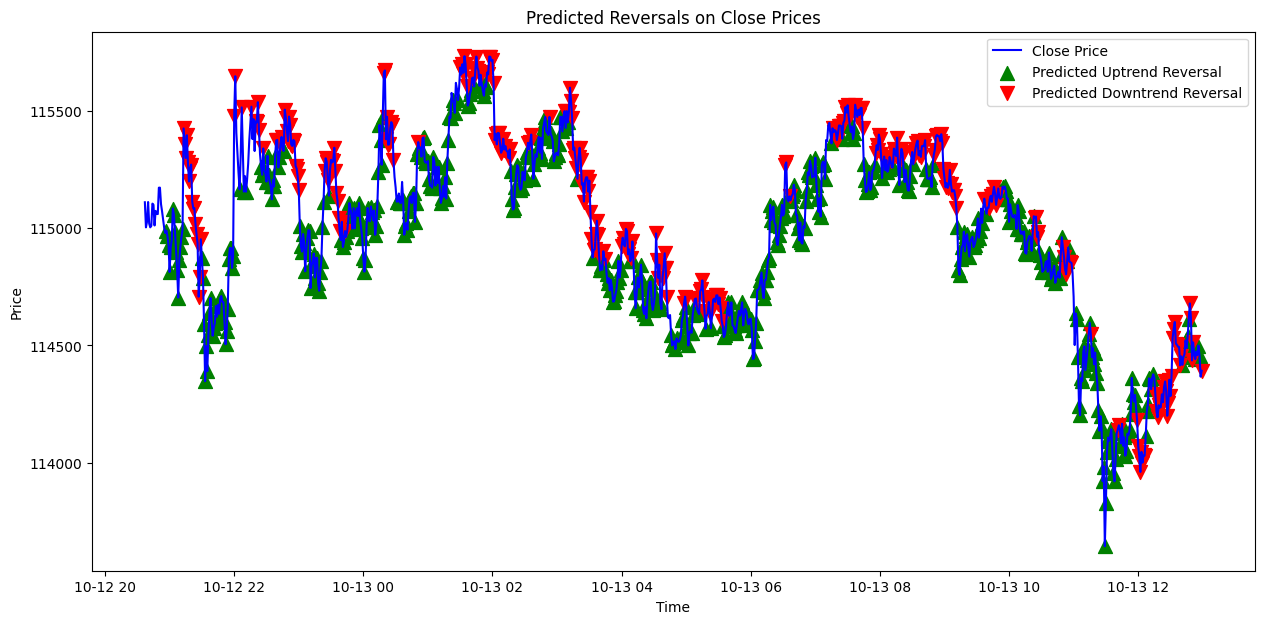

In [ ]:
# ===============================
# 5. Plot Close prices with predicted reversals
# ===============================
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(df.index, df["close"], label="Close Price", color="blue")

# Uptrend reversals (label=2)
plt.scatter(df.index[df["Predicted"]==2], df["close"][df["Predicted"]==2],
            marker="^", color="green", s=100, label="Predicted Uptrend Reversal")

# Downtrend reversals (label=0)
plt.scatter(df.index[df["Predicted"]==0], df["close"][df["Predicted"]==0],
            marker="v", color="red", s=100, label="Predicted Downtrend Reversal")

plt.title("Predicted Reversals on Close Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

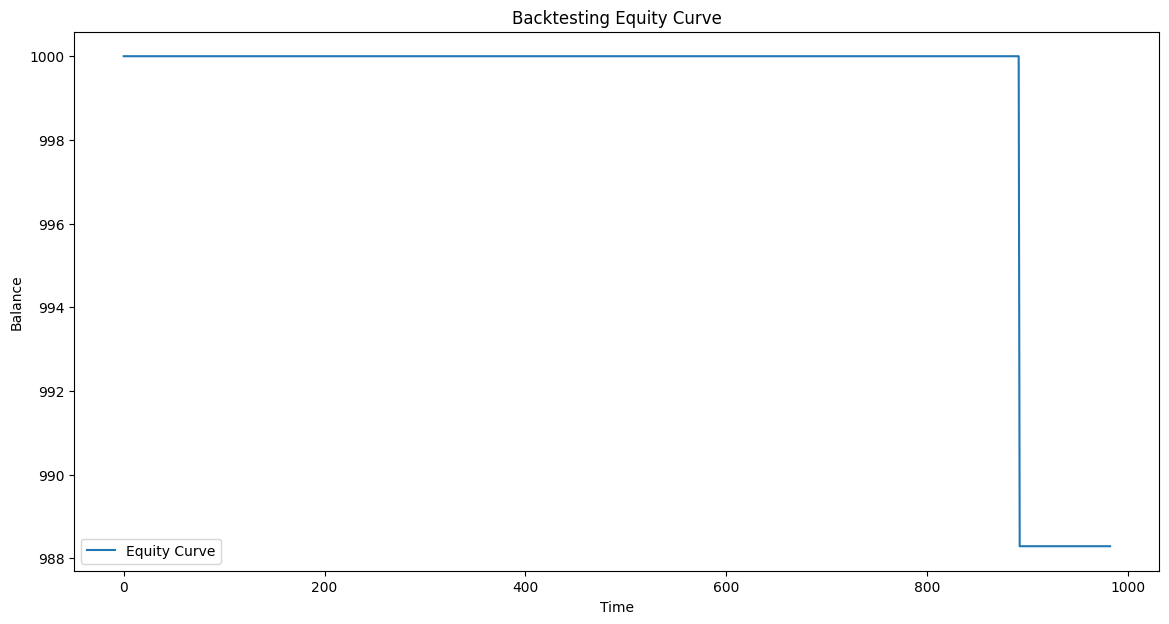

Initial Balance: 1000
Final Balance: 988.29
Total Return: -1.17%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your CSV with predicted labels
  # use the file after running the prediction script

# Parameters
initial_balance = 1000
balance = initial_balance
position = 0      # +1 = long, -1 = short, 0 = no position
entry_price = 0
take_profit = 0.02   # 2% TP
stop_loss = 0.01     # 1% SL
equity_curve = []

for i in range(len(df)):
    price = df["close"].iloc[i]
    pred = df["Predicted"].iloc[i]

    # Close existing position if TP/SL hit
    if position == 1:  # long
        if price >= entry_price*(1+take_profit) or price <= entry_price*(1-stop_loss):
            balance *= (price/entry_price)
            position = 0
            entry_price = 0
    elif position == -1:  # short
        if price <= entry_price*(1-take_profit) or price >= entry_price*(1+stop_loss):
            balance *= (2 - price/entry_price)  # profit for short
            position = 0
            entry_price = 0

    # Open new position based on prediction
    if position == 0:
        if pred == 2:  # predicted uptrend reversal -> long
            position = 1
            entry_price = price
        elif pred == 0:  # predicted downtrend reversal -> short
            position = -1
            entry_price = price

    equity_curve.append(balance)

# ===============================
# Plot Equity Curve
# ===============================
plt.figure(figsize=(14,7))
plt.plot(equity_curve, label="Equity Curve")
plt.title("Backtesting Equity Curve")
plt.xlabel("Time")
plt.ylabel("Balance")
plt.legend()
plt.show()

print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {balance:.2f}")
print(f"Total Return: {(balance-initial_balance)/initial_balance*100:.2f}%")


In [ ]:
df.shape

(983, 19)